# Pairs Trading Backtest (2nd Project)
Tests a mean reversion strategy on two cointegrated stocks, Coca-Cola and Pepsi, by calculating the spread & tracking its average and standard deviation.

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load Data
Closing price is retrieved for both stocks, then the spread is calculated

In [ ]:
def loadData(code1="KO", code2="PEP", start="2023-01-01", end="2024-01-01"):

    data = yf.download([code2, code1], start, end)["Close"]
    spread = data[code2] - data[code1]

    return data, spread, code1, code2

## Signal Generation
Moving average and standard deviation of the spread is calculated.

Trading signals are generated for mean reversion, and noise is reduced with a confirmation lag; now a confirmation signal is added to the data frame.

In [ ]:
def signals(data, spread, code1, code2):
    spread_mew = spread.rolling(window=20).mean()
    spread_sigma = spread.rolling(window=20).std()

    data["Mew"] = spread_mew
    data["Sigma"] = spread_sigma
    data["Spread"] = spread

    data["Signal"] = 0
    data.loc[spread > spread_mew + 2 * spread_sigma, "Signal"] = 1   # short a long b
    data.loc[spread < spread_mew - 2 * spread_sigma, "Signal"] = -1  # long a short b

    # trending 2days in a row, not just once
    confirmed = (
        (data["Signal"] == data["Signal"].shift(1)) &
        (data["Signal"] != 0)
    )
    data["ConfirmedSignal"] = data["Signal"].where(confirmed, 0)

    return data, code1, code2

## Backtest
Strategy enters short/long positions depending on the predefined signals and the stock data. It uses the confirm signal in the dataframe as the condition. It saves the portfolio value to the data frame for later representation.

In [ ]:

def backtest(data, code1, code2, cash=10000, transactionFee=0.001):
    a_stocks = 0
    b_stocks = 0

    for date, row in data.iterrows():
        if pd.isna(row["Mew"]) or pd.isna(row["Spread"]):
            continue

        spread = row["Spread"]
        signal = row["ConfirmedSignal"]
        a_price = row[code1]
        b_price = row[code2]

        if signal == 1:
            aValue = a_stocks * a_price # sell a buy b
            cash += aValue * (1 - transactionFee)
            a_stocks = 0
            b_stocks += cash / b_price
            cash -= cash * transactionFee
            cash = 0

        elif signal == -1: # sell b buy a
            bValue = b_stocks * b_price
            cash += bValue * (1 - transactionFee)
            b_stocks = 0
            a_stocks += cash / a_price
            cash -= cash * transactionFee
            cash = 0

        value = a_stocks * a_price + b_stocks * b_price + cash
        data.loc[date, "Portfolio"] = value

    print(f"Started at 10000, ended at {value:.2f}")
    return data, code1, code2


## Representation/Evaluation
Performance is visualised using a graph to plot the two stocks & spread, and a separate graph is drawn for portfolio value for clarity.

In [ ]:
def graph(data, code1, code2):
    plt.figure(figsize=(10, 5))

    # plot 1
    plt.subplot(2, 1, 1)
    data[code1].plot(title="KO vs PEP Prices", ax=plt.gca())
    data[code2].plot(ax=plt.gca(), label='PEP')
    spread= data["Spread"]
    spread.plot(ax=plt.gca(), label='Spread', color='green')
    plt.legend([code1, code2, 'Spread'])

    # Plot 2
    plt.subplot(2, 1, 2)
    portfolio = data["Portfolio"]
    portfolio.plot(title="Portfolio Value", ax=plt.gca())
    plt.legend(['Portfolio'])

    plt.tight_layout()
    plt.show()

/tmp/ipython-input-2-4152695583.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download([code2, code1], start, end)["Close"]
[*********************100%***********************]  2 of 2 completed


Started at 10000, ended at 9803.18


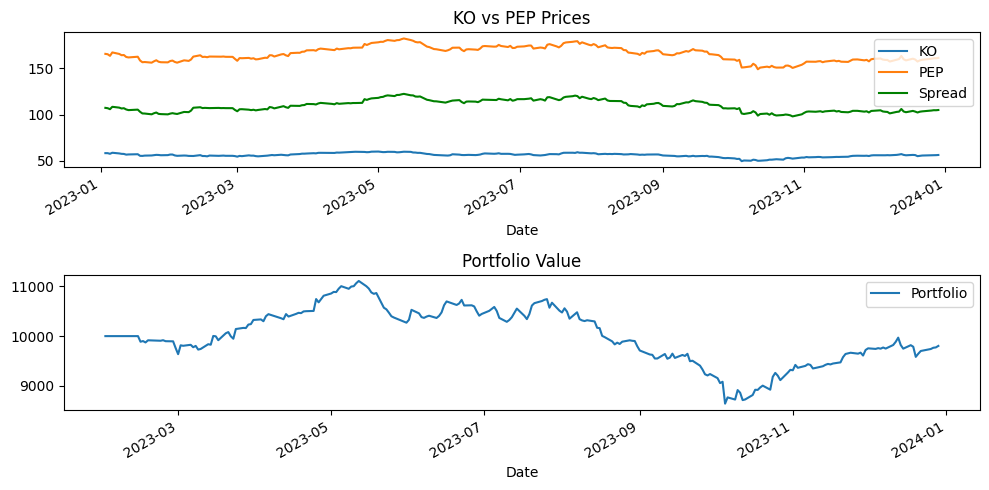

In [ ]:
def main():
    data, spread, code1, code2 = loadData()
    data, code1, code2 = signals(data, spread, code1, code2)
    data, code1, code2 = backtest(data, code1, code2)
    graph(data, code1, code2)

if __name__ == "__main__":
    main()

## Conclusion/Improvements
A similar structure to the 1st project was followed, this time taking two stocks and deriving more data like spread, mean, and STD. This time, a mean reversion strategy was used as cointegrated stocks tend to follow similar trends, and a confirmation lag was used to avoid biting on weak/noisy signals.

Improvements:

Although the strategy is built on the classic mean-reversion logic of pairs trading, it underperforms in this case. Upon analysis, the KO/PEP spread did not exhibit strong mean-reverting behavior over the selected timeframe, instead following steady trends. This demonstrates the risk of such strategies without validating stationarity of the asset pair. In future iterations, I would explore other pair combinations and statistical tests to ensure better structural conditions, as well as tiered partial allocation signals. Tracking metrics more explicitly would help evaluate the trading strategy.